In [1]:
import os,glob
import numpy as np
import scipy.io
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torchvision.transforms.functional as TF

import matplotlib.pyplot as plt

import models

# Define rotations to rotate image 
rotations = [0, 45, 90, 135, 180, 225, 270, 315]
# rotations = [0,90]
num_rot = len(rotations)
digits = [4,9]
# Define transformation to convert image to tensor
transform = transforms.ToTensor()

# Load MNIST train and test datasets
trainset = datasets.MNIST('data', train=True, download=True, transform=transform)
testset = datasets.MNIST('data', train=False, download=True, transform=transform)

# Define filter function to only include images of digits 5 and 6
def filter_dataset(dataset):
    filtered_data = []
    for i in range(len(dataset)):
        image, label = dataset[i]
        if label == digits[0] or label == digits[1]:
            label = 0 if label==digits[0] else 1
            for angle in rotations:
                rotated_img = TF.rotate(image, angle)#torch.rot90(image, angle // 45)
                filtered_data.append((rotated_img.flatten(), label, angle))
                
    return filtered_data

# Filter train and test datasets to only include images of digits 5 and 6
trainset_filtered = filter_dataset(trainset)
testset_filtered = filter_dataset(testset)

# Define dataloaders for train and test datasets
train_dataloader = torch.utils.data.DataLoader(trainset_filtered, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(testset_filtered, batch_size=32, shuffle=True)

#data dimensions
input_dim = trainset_filtered[0][0].shape[0]
output_dim = 1 


In [ ]:
# parameters
gpu = torch.device('cpu')

ML_model_name = "fc_stg_layered_param_modular_model_sigmoid"

num_epoch = 10
# input_dim = no. of explanatory features
input_dim = 784
# input_dim = no. of contextual features
param_dim = 8
# 
output_dim = 1

# parametric stg
stg,include_B_in_input,non_param_stg = (True,False,False)
# # stg - with contextual information NOT feeding into classifier
# stg,include_B_in_input,non_param_stg = (True,False,True)
# # stg - with contextual information feeding into classifier
# stg,include_B_in_input,non_param_stg = (True,True,True)
# # no gates 
# stg,include_B_in_input,non_param_stg = (False,False,False)
# # no gates - with contextual information feeding into classifier
# stg,include_B_in_input,non_param_stg = (False,True,False)

# parameters of the model architecture
hyper_hidden_dims = [[1000]]
hidden_dims = [[]]

# hyper parameters for training the model
learning_rates = [5e-4]
stg_regularizers = [5e-2]

dropout = 0
train_sigma = False


for hyper_hidden_dim in hyper_hidden_dims: 
    for hidden_dim in hidden_dims: 
        for learning_rate in learning_rates:
            for stg_regularizer in stg_regularizers:
                
                # Load model architecture
                model = models.__dict__[ML_model_name](input_dim, hidden_dims, output_dim, param_dim, hyper_hidden_dim, dropout,include_B_in_input=include_B_in_input,non_param_stg=non_param_stg,train_sigma=train_sigma)
                model = model.to(gpu).float()
                print(model)
                criterion = nn.BCELoss()  
                optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999))



In [ ]:
# Training
def train(model,x_train,y_train_one_hot, r_train,x_dev, y_dev,r_dev,num_epoch=num_epoch):
    if len(y_train_one_hot.shape)==1:
        y_train_one_hot = y_train_one_hot[:,None]
    if len(y_dev.shape)==1:
        y_train_one_hot = y_train_one_hot[:,None]
    if len(r_train.shape)==1:
        r_train = r_train[:,None]
    if len(r_dev.shape)==1:
        r_dev = r_dev[:,None]
        
    train_set = data_utils.TensorDataset(torch.tensor(x_train), torch.tensor(y_train_one_hot), torch.tensor(r_train))
    test_set = data_utils.TensorDataset(torch.tensor(x_dev), torch.tensor(y_dev), torch.tensor(r_dev))
    
    # Define dataloaders for train and test datasets
    train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
    test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)

    for epoch in range(num_epoch):
        
        for batch, (input, target, B) in enumerate(train_dataloader):

            model.train()

            input = input.to(gpu).float()
            target = target.to(gpu).float()
            B = B.to(gpu).float()
            
            output = model(input,B)
            output = torch.squeeze(output)
            loss = criterion(output, torch.squeeze(target)) #.long()

            temp = model.gates.mu
            grads = temp.squeeze().cpu().detach().numpy()

            stg_loss = torch.mean(torch.abs(model.reg((model.gates.mu)))) 
    #                                 print(loss.item(),stg_loss.item())
            loss += stg_regularizer*stg_loss

            optimizer.zero_grad()   
            with torch.autograd.set_detect_anomaly(True):
                loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0, norm_type=2)
            optimizer.step()

            loss_value = loss.item()
#             train_loss += loss.item()
#             train_count += len(input)
            
        model.eval()
#         sigma.append(model.gates.sigma.detach().cpu().numpy()[0])
        train_loss = 0
        test_loss = 0
        train_count = 0
        test_count = 0
        test_acc_array = [0]
        train_acc_array = [0]
        train_loss_array = [0]
        test_loss_array = [0]
        train_acc_batch = []
        test_acc_batch = []
        
        for batch, (input, target, B) in enumerate(train_dataloader):
            input = input.to(gpu).float()
            target = target.to(gpu).float()
            B = B.to(gpu).float()
            
            output = model(input,B)
            output = torch.squeeze(output)
            loss = criterion(output, torch.squeeze(target))
            train_acc_batch.append(accuracy_score((output>0.5).float().detach().cpu().numpy(), target.detach().cpu().numpy()))
            loss += stg_regularizer*torch.mean(model.reg((model.gates.mu))) 
            train_loss += loss.item()*len(input)
            train_count += len(input)
        train_acc = np.mean(train_acc_batch)*100
        train_acc_array.append(train_acc)
        train_loss_array.append(train_loss/train_count)

        
        for batch, (input, target, B) in enumerate(test_dataloader):
            input = input.to(gpu).float()
            target = target.to(gpu).float()
            B = B.to(gpu).float()
            
            output = model(input,B)
            output = torch.squeeze(output)

            test_acc_batch.append(accuracy_score((output>0.5).float().detach().cpu().numpy(), target.detach().cpu().numpy()))
            loss = criterion(output, torch.squeeze(target))

            loss += stg_regularizer*torch.mean(model.reg(model.gates.mu)) 

            test_loss += loss.item()*len(input)
            test_count += len(input)
        test_acc = np.mean(test_acc_batch)*100
        test_acc_array.append(test_acc)
        test_loss_array.append(test_loss/test_count)
        return train_acc_array,train_loss_array,test_acc_array,test_loss_array

def test(model,x_test,r_test):
    if len(r_test.shape)==1:
        r_test = r_test[:,None]
    
    test_set = data_utils.TensorDataset(torch.tensor(x_test), torch.tensor(r_test))
    
    # Define dataloaders for train and test datasets
    test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)
    y_pred = None
    model.eval()
    for batch, (input, B) in enumerate(test_dataloader):
        input = input.to(gpu).float()
        B = B.to(gpu).float()
        
        output = model(input,B)
        output = torch.squeeze(output)
        y_pred_cur = (output).float().detach().cpu().numpy().reshape(-1,1)
        if y_pred is None:
            y_pred = y_pred_cur
        else:
            y_pred = np.vstack((y_pred,y_pred_cur))
    return y_pred

def get_prob_alpha(model,r):
    if len(r.shape)==1:
        r = r[:,None]
    B = torch.tensor(r)
    B = B.to(gpu).float()
    
    model.eval()
    
    mu = model.gates.get_feature_importance(B)
    mu = mu.detach().cpu().numpy()
    
    return mu
    

/fc_stg_layered_param_modular_model_sigmoid_4_9_lr_0_0005_stg_lr_0_05_784_128_32_8_1_hyper_8_64_128_784.model
FC_STG_Layered_Param_modular_model_sigmoid(
  (gates): FeatureSelector(
    (hyper_dense_layers): ModuleList(
      (0): Linear(in_features=8, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=784, bias=True)
      (5): Sigmoid()
    )
  )
  (dense_layers): ModuleList(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


  0%|                                                    | 0/10 [00:00<?, ?it/s]

epoch 1/10: train_loss=0.74216, test_loss=0.74201, train_acc:50.45, test_acc:50.67
Model saved! Validation accuracy improved from 0.000000 to 50.671436


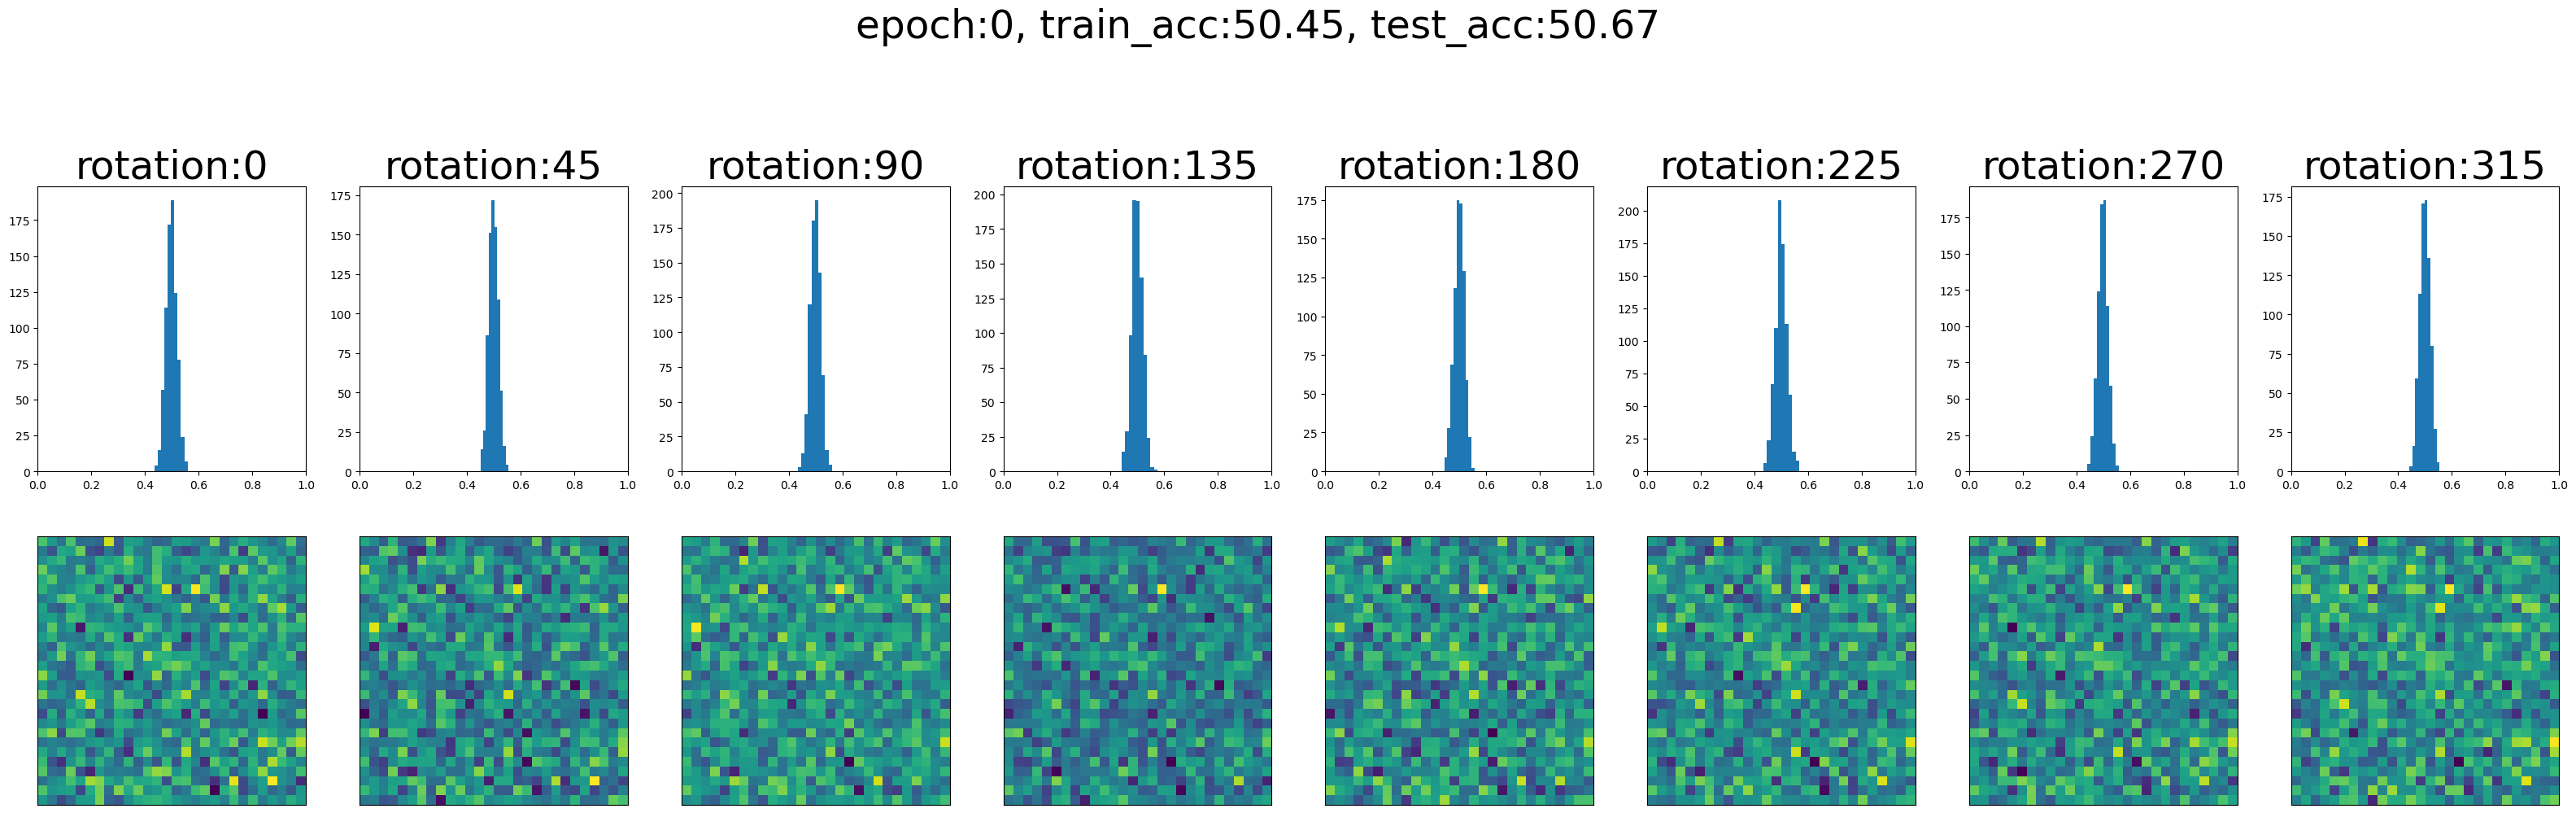

 10%|████▍                                       | 1/10 [00:06<00:59,  6.62s/it]

epoch 2/10: train_loss=0.07148, test_loss=0.15215, train_acc:96.19, test_acc:95.66
Model saved! Validation accuracy improved from 50.671436 to 95.663906


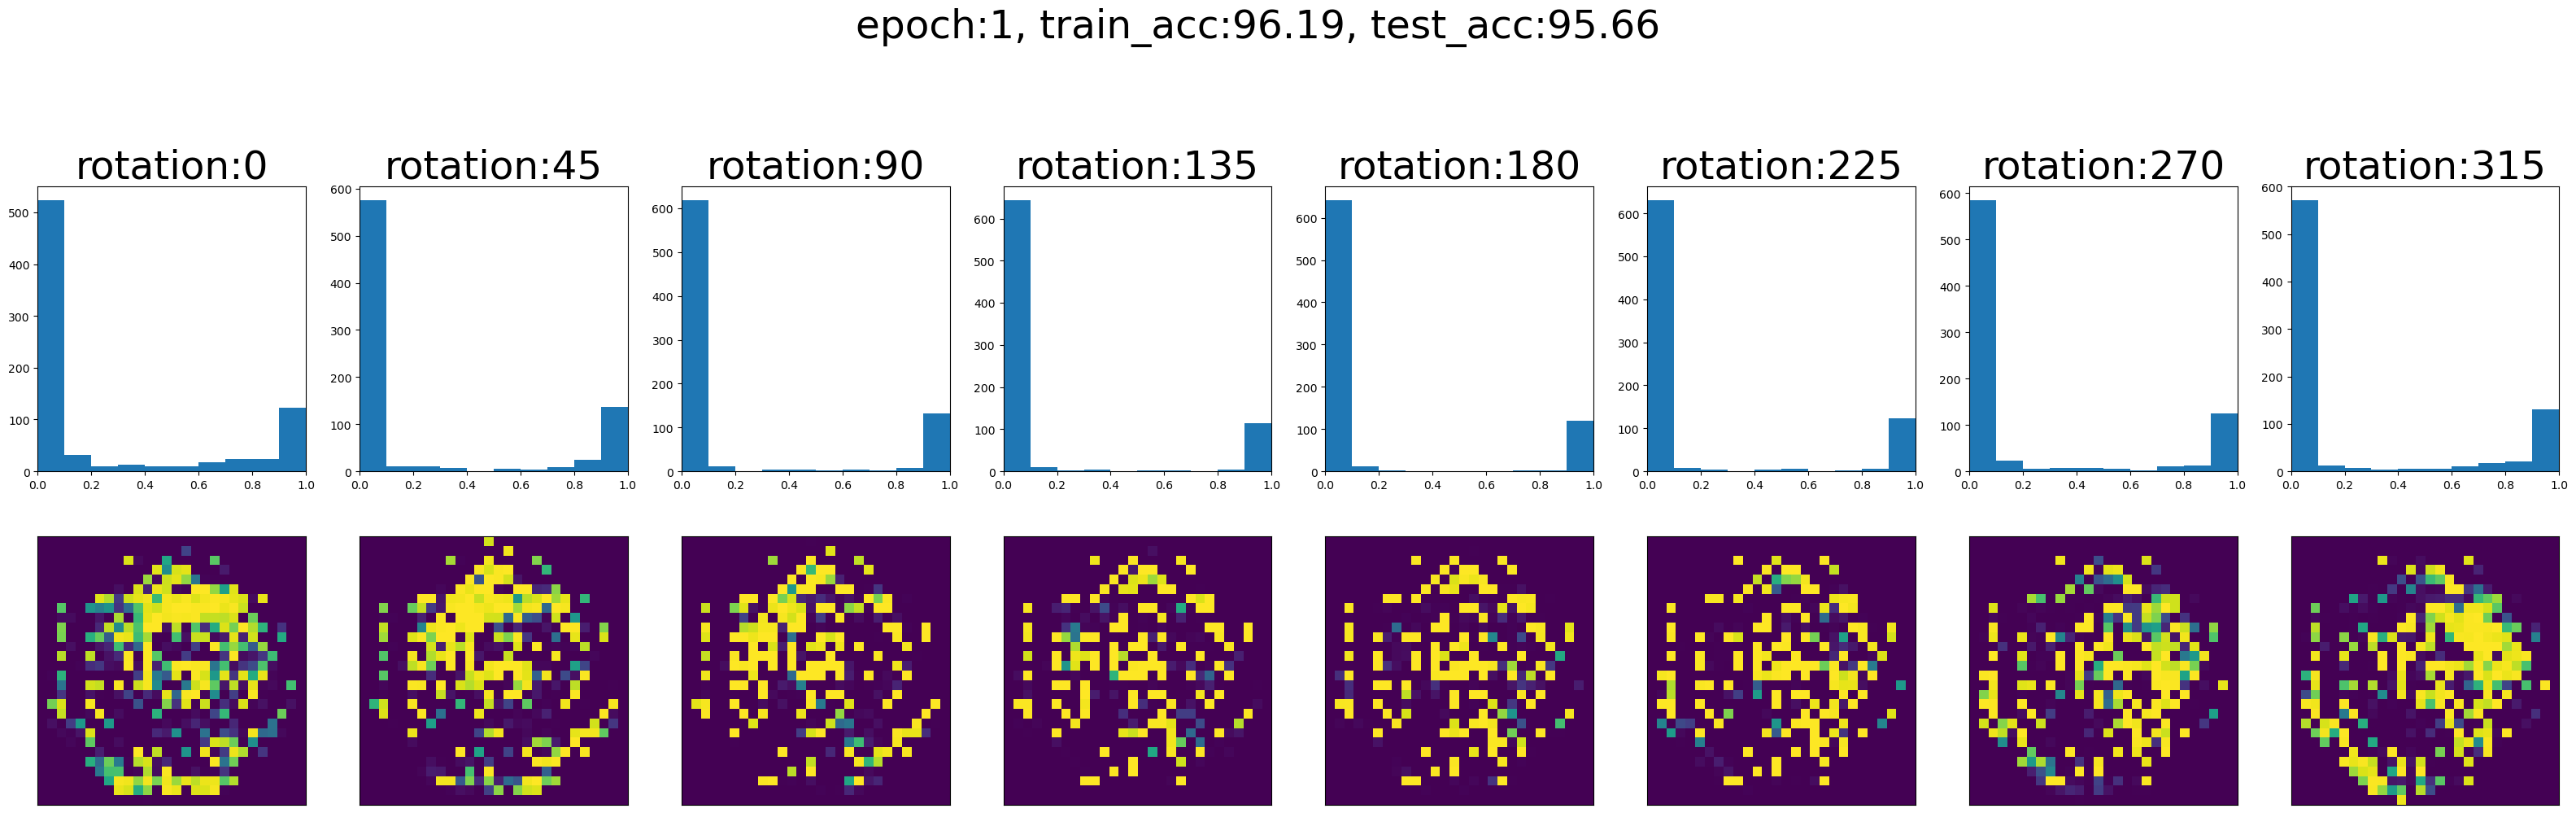

 20%|████████▊                                   | 2/10 [00:46<03:28, 26.10s/it]

epoch 3/10: train_loss=0.05463, test_loss=0.12952, train_acc:97.36, test_acc:96.68
Model saved! Validation accuracy improved from 95.663906 to 96.680472


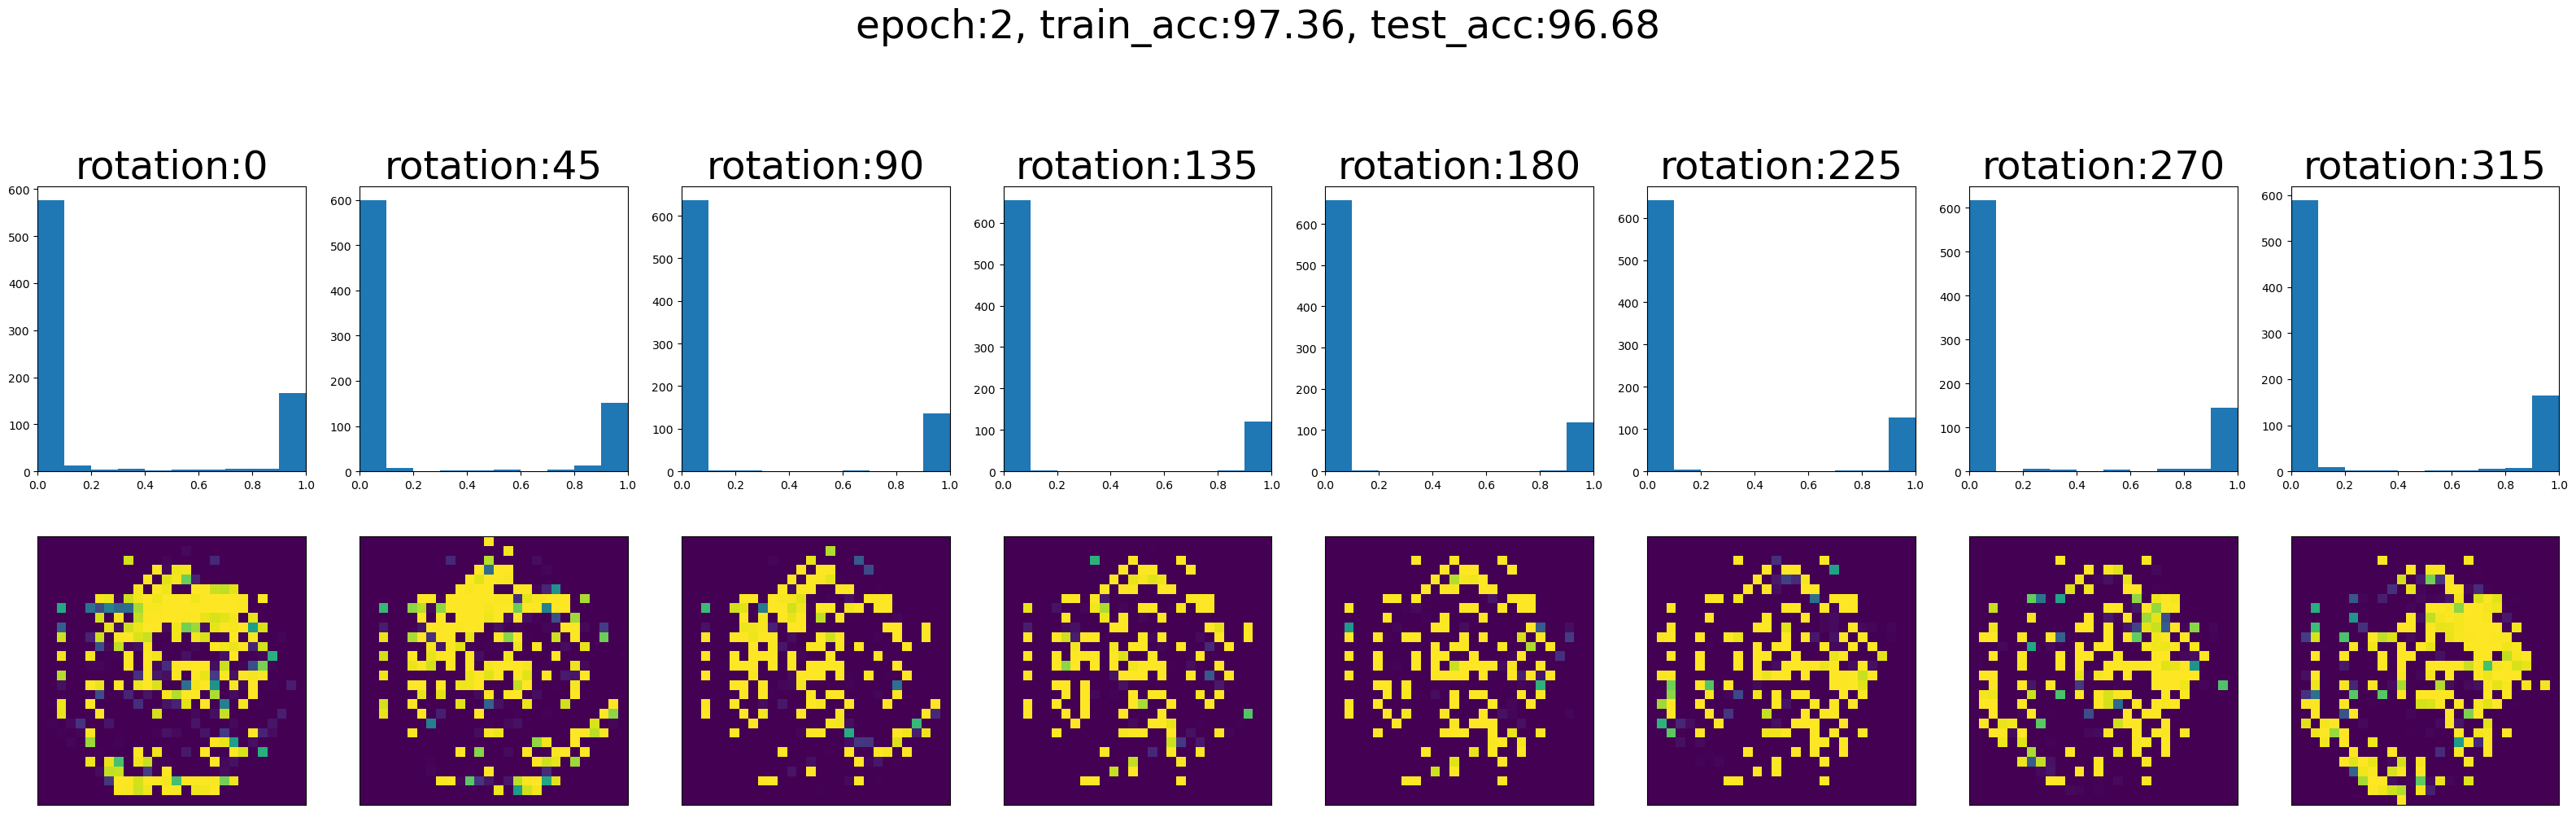

 30%|█████████████▏                              | 3/10 [01:26<03:47, 32.44s/it]

epoch 4/10: train_loss=0.04774, test_loss=0.11765, train_acc:97.81, test_acc:96.94
Model saved! Validation accuracy improved from 96.680472 to 96.944026


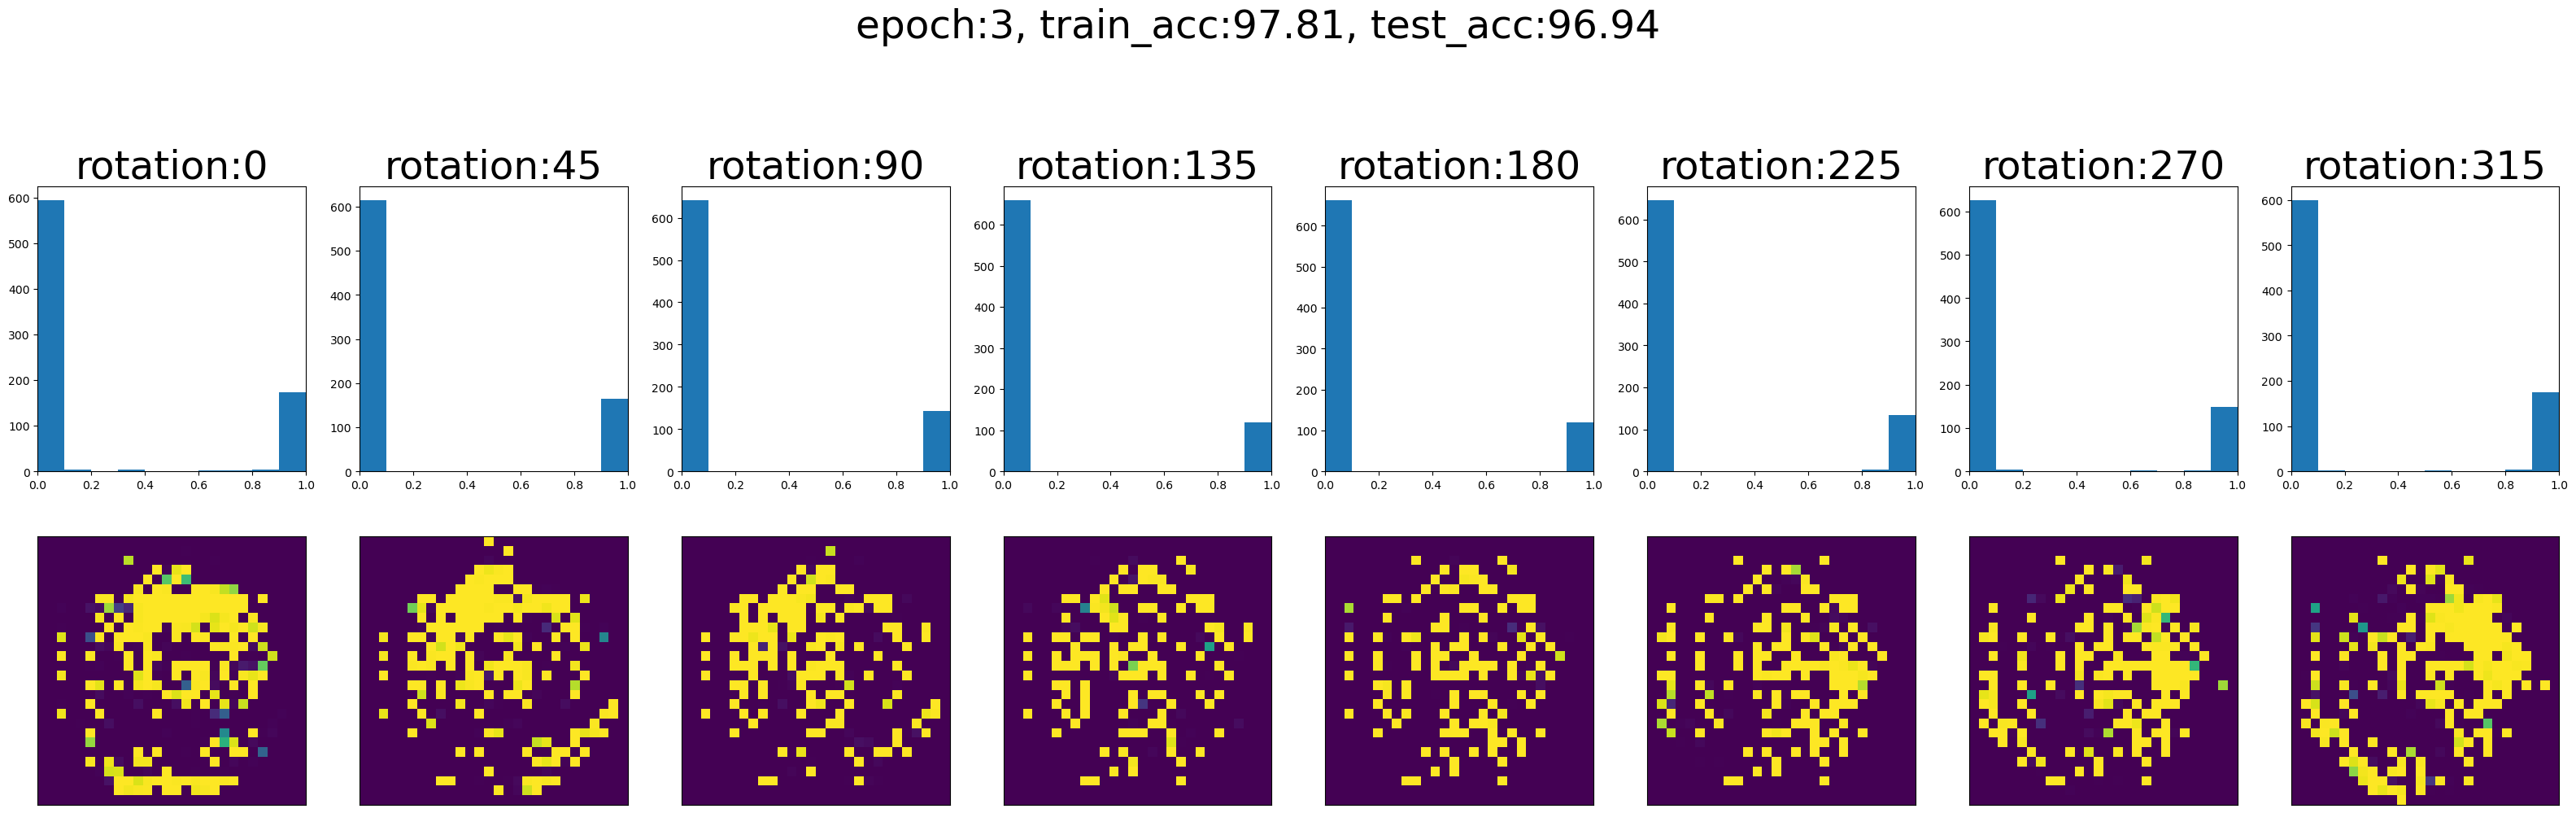

 40%|█████████████████▌                          | 4/10 [02:06<03:31, 35.33s/it]

epoch 5/10: train_loss=0.04564, test_loss=0.11567, train_acc:98.04, test_acc:97.21
Model saved! Validation accuracy improved from 96.944026 to 97.205489


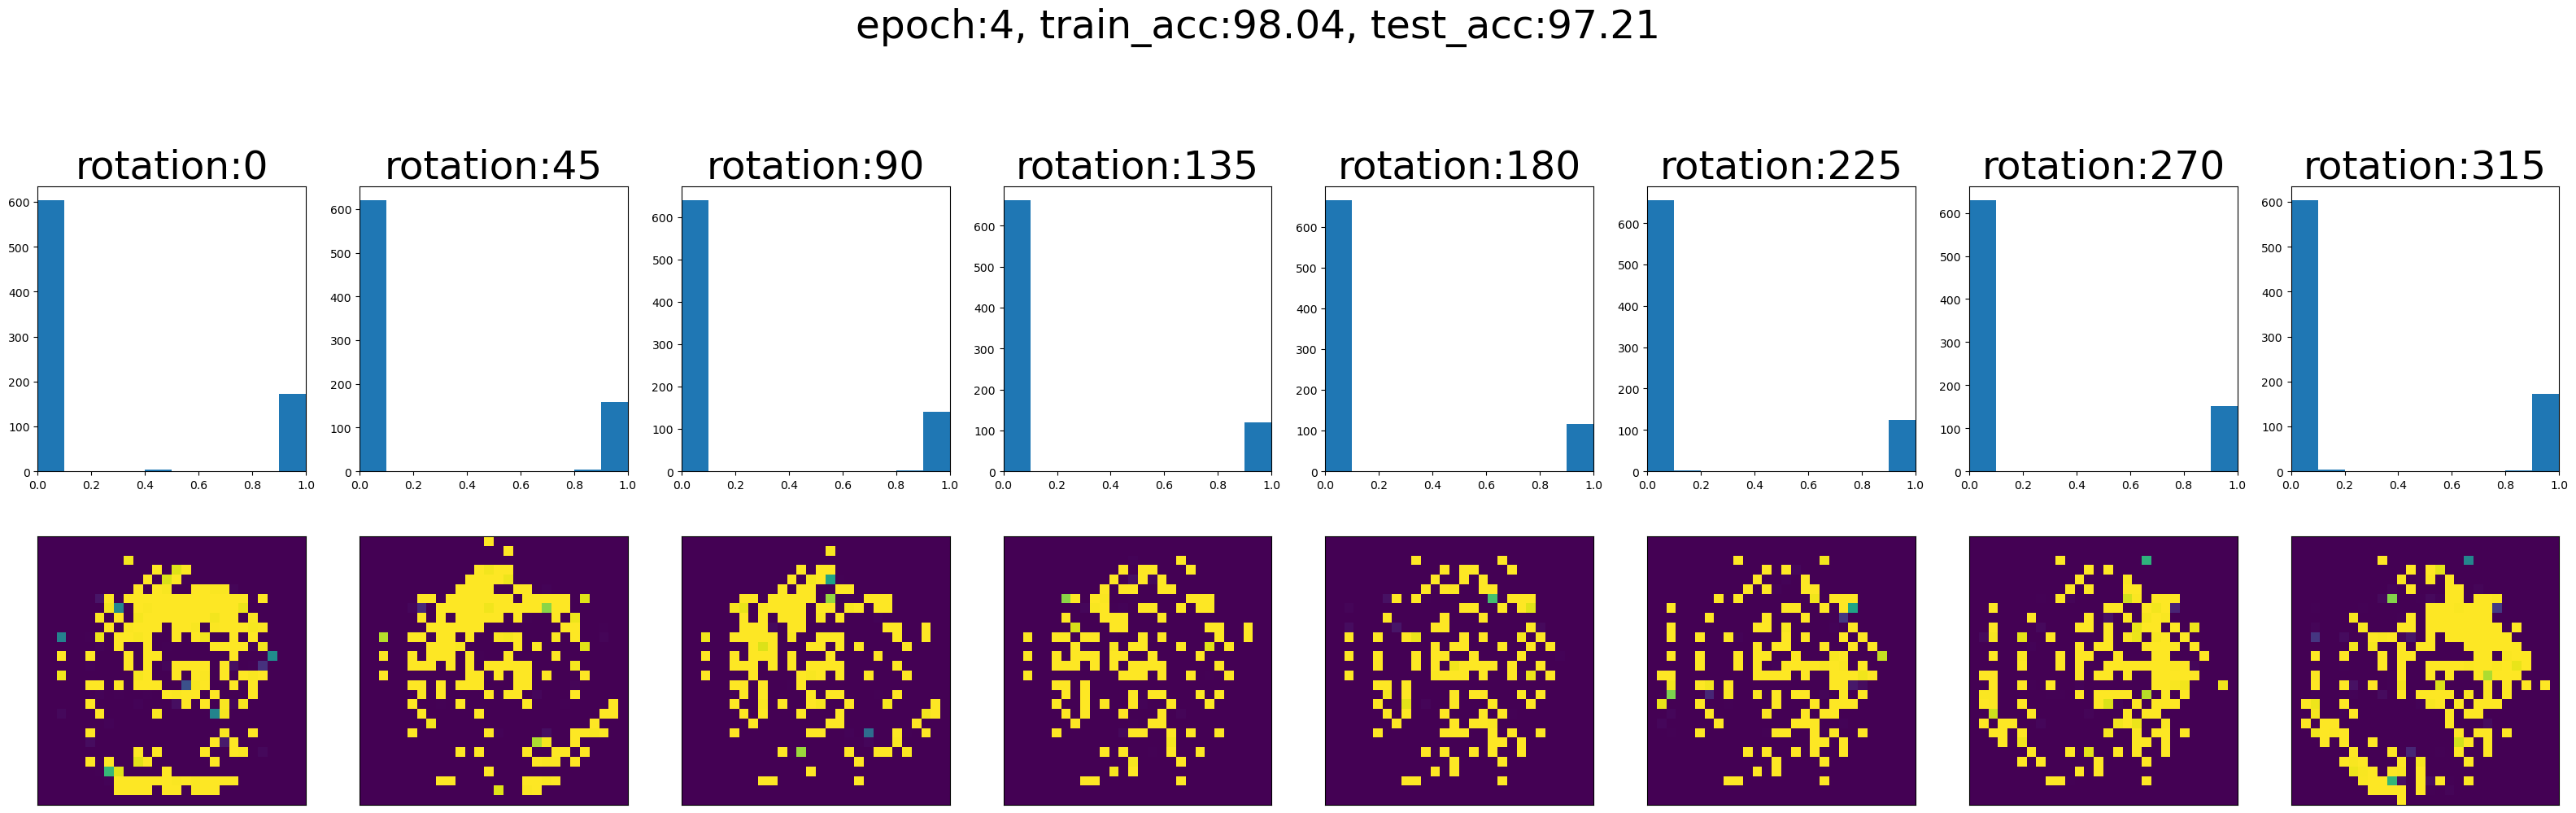

 50%|██████████████████████                      | 5/10 [02:45<03:04, 36.84s/it]

epoch 6/10: train_loss=0.04164, test_loss=0.10775, train_acc:98.33, test_acc:97.60
Model saved! Validation accuracy improved from 97.205489 to 97.600820


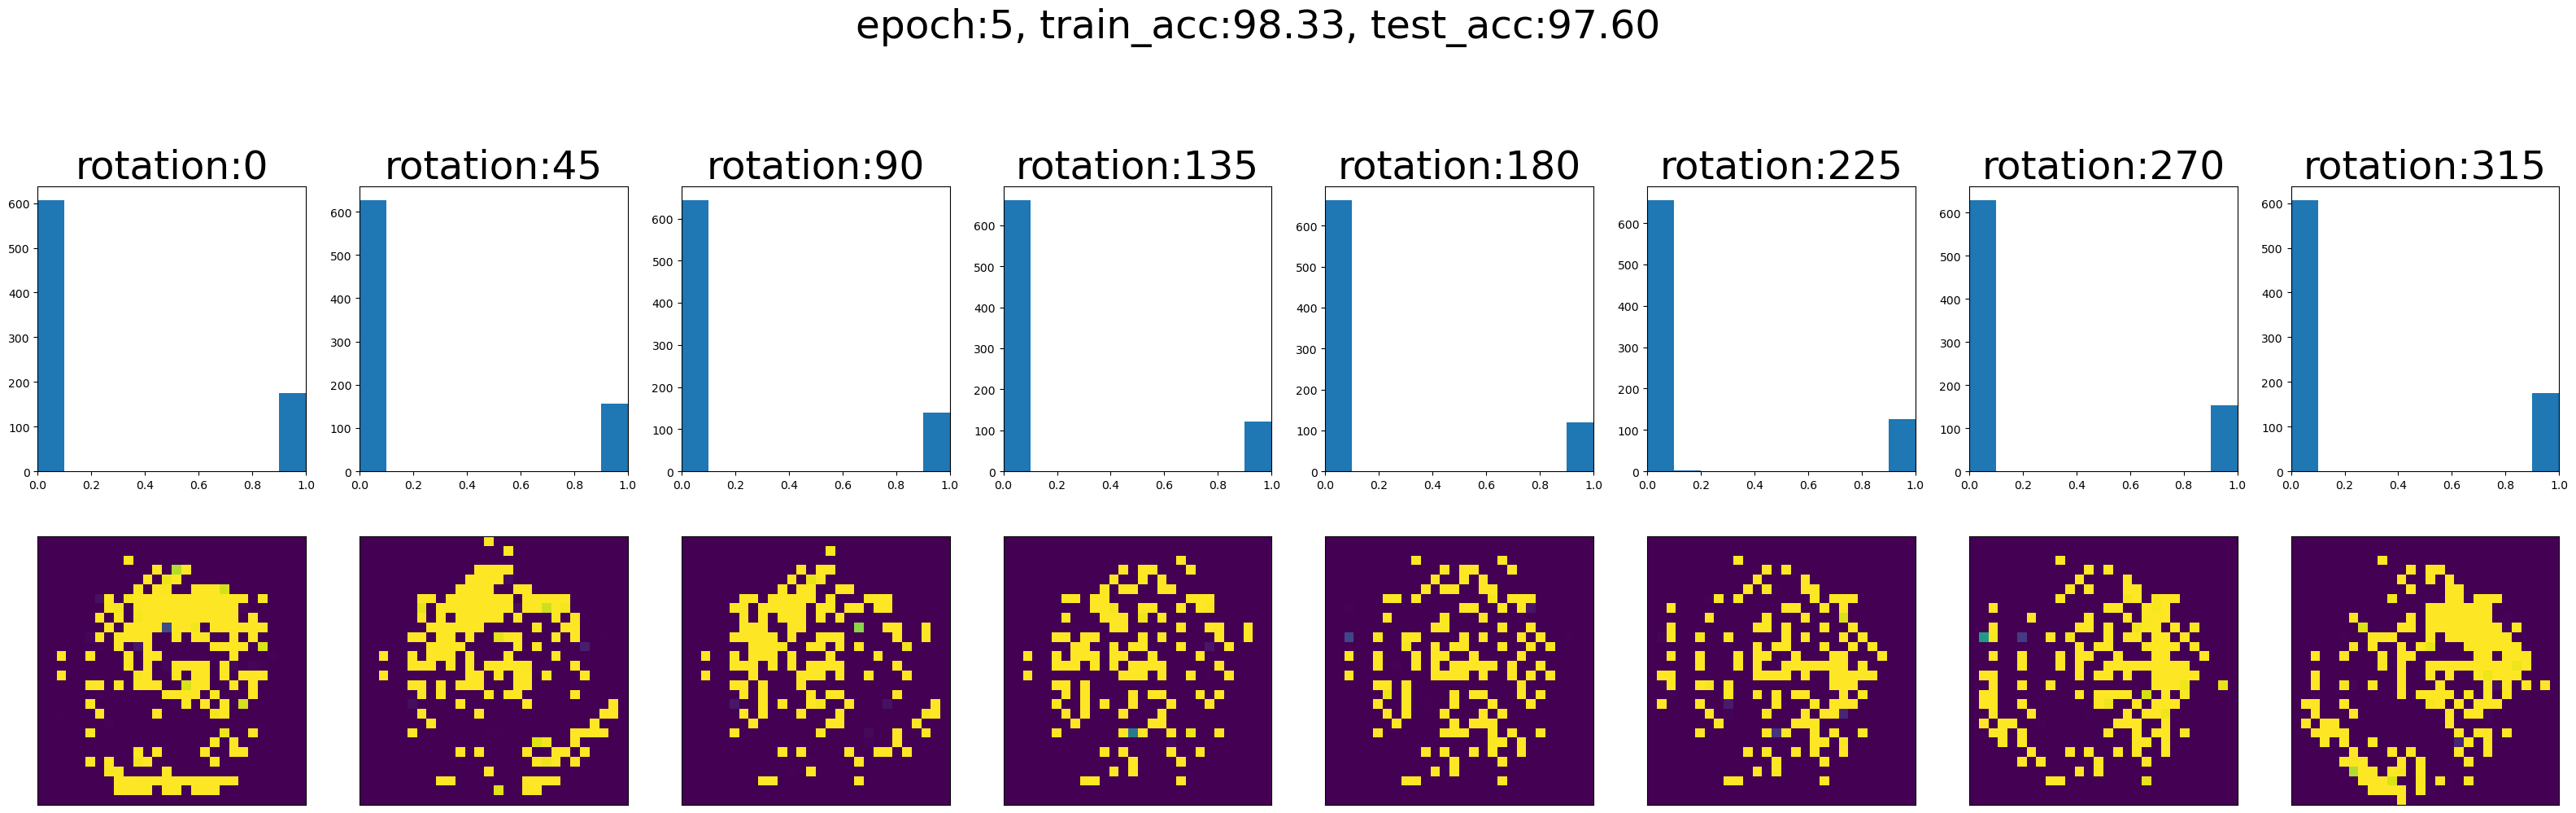

 60%|██████████████████████████▍                 | 6/10 [03:26<02:32, 38.09s/it]

epoch 7/10: train_loss=0.04190, test_loss=0.10379, train_acc:98.26, test_acc:97.50


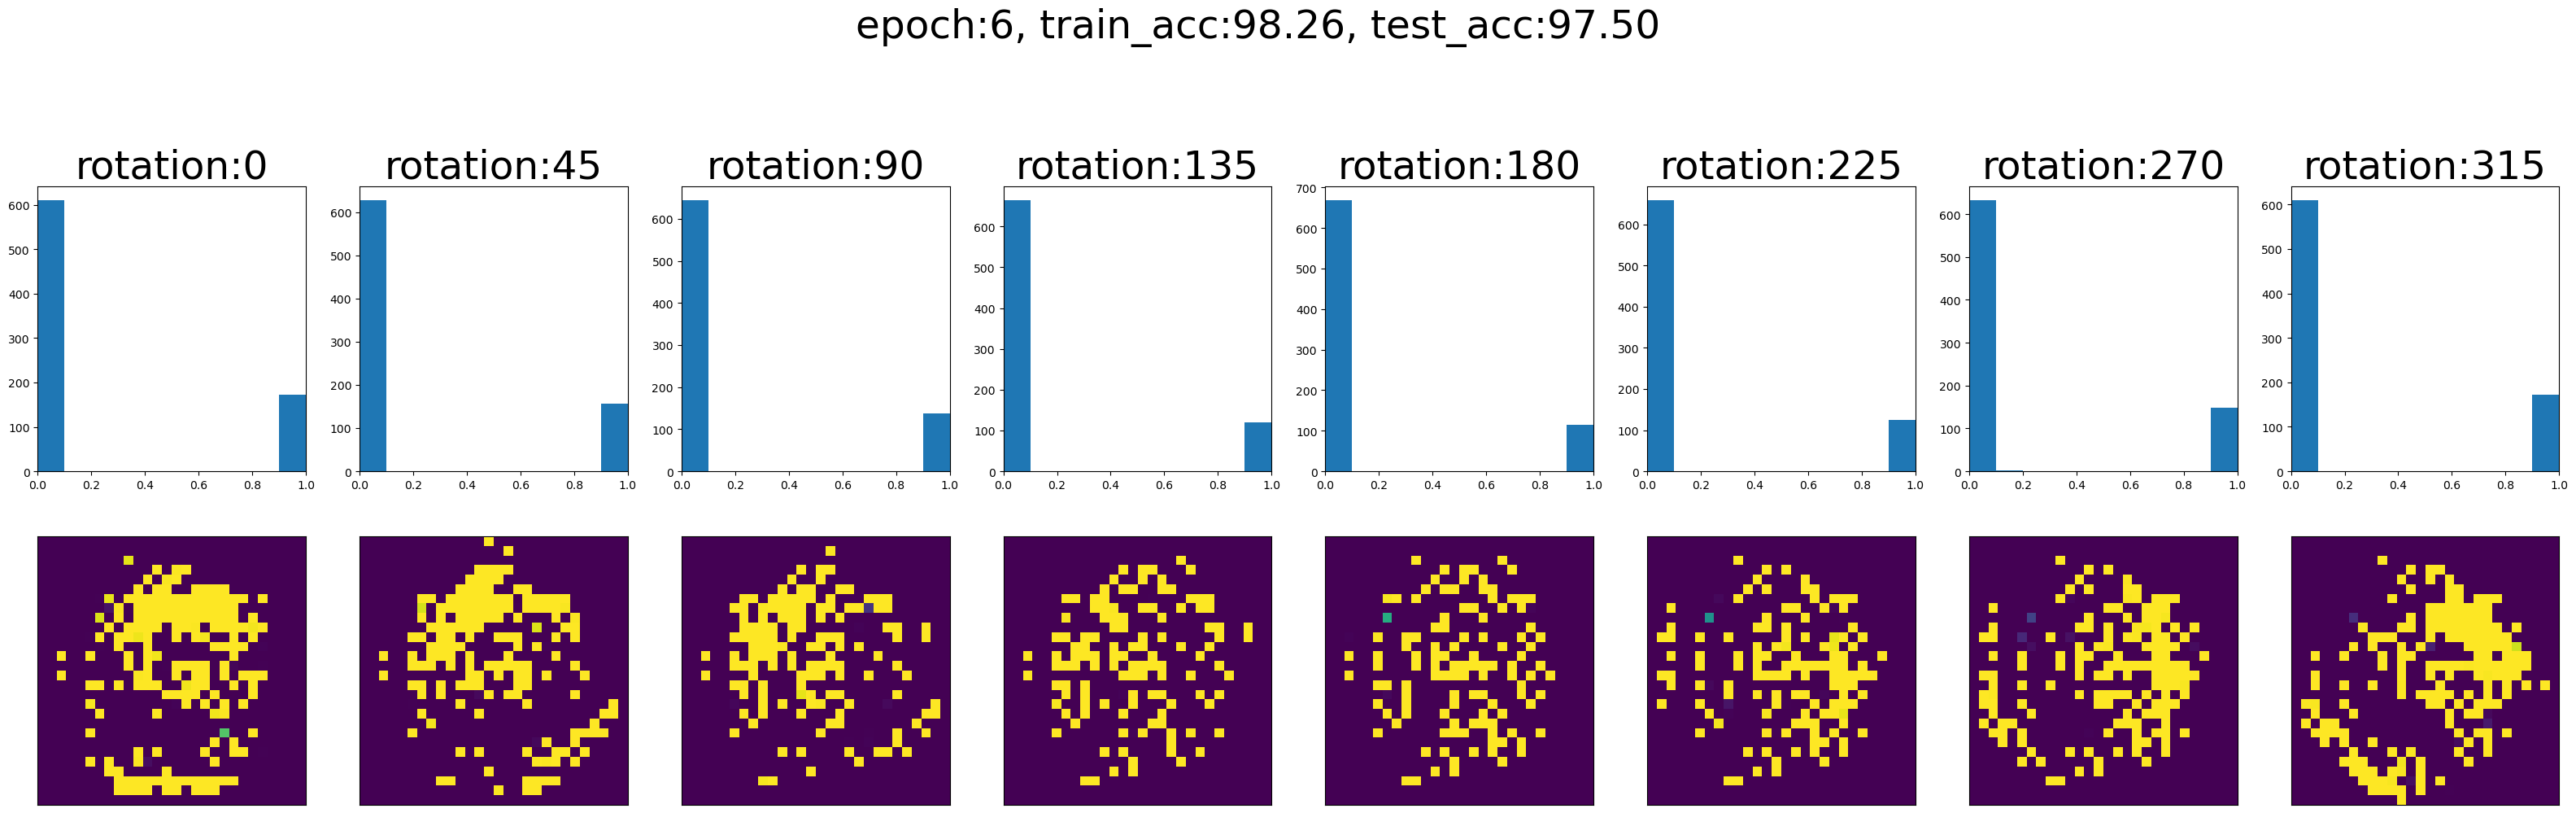

 70%|██████████████████████████████▊             | 7/10 [04:05<01:55, 38.58s/it]

epoch 8/10: train_loss=0.03647, test_loss=0.10073, train_acc:98.63, test_acc:97.79
Model saved! Validation accuracy improved from 97.600820 to 97.791165


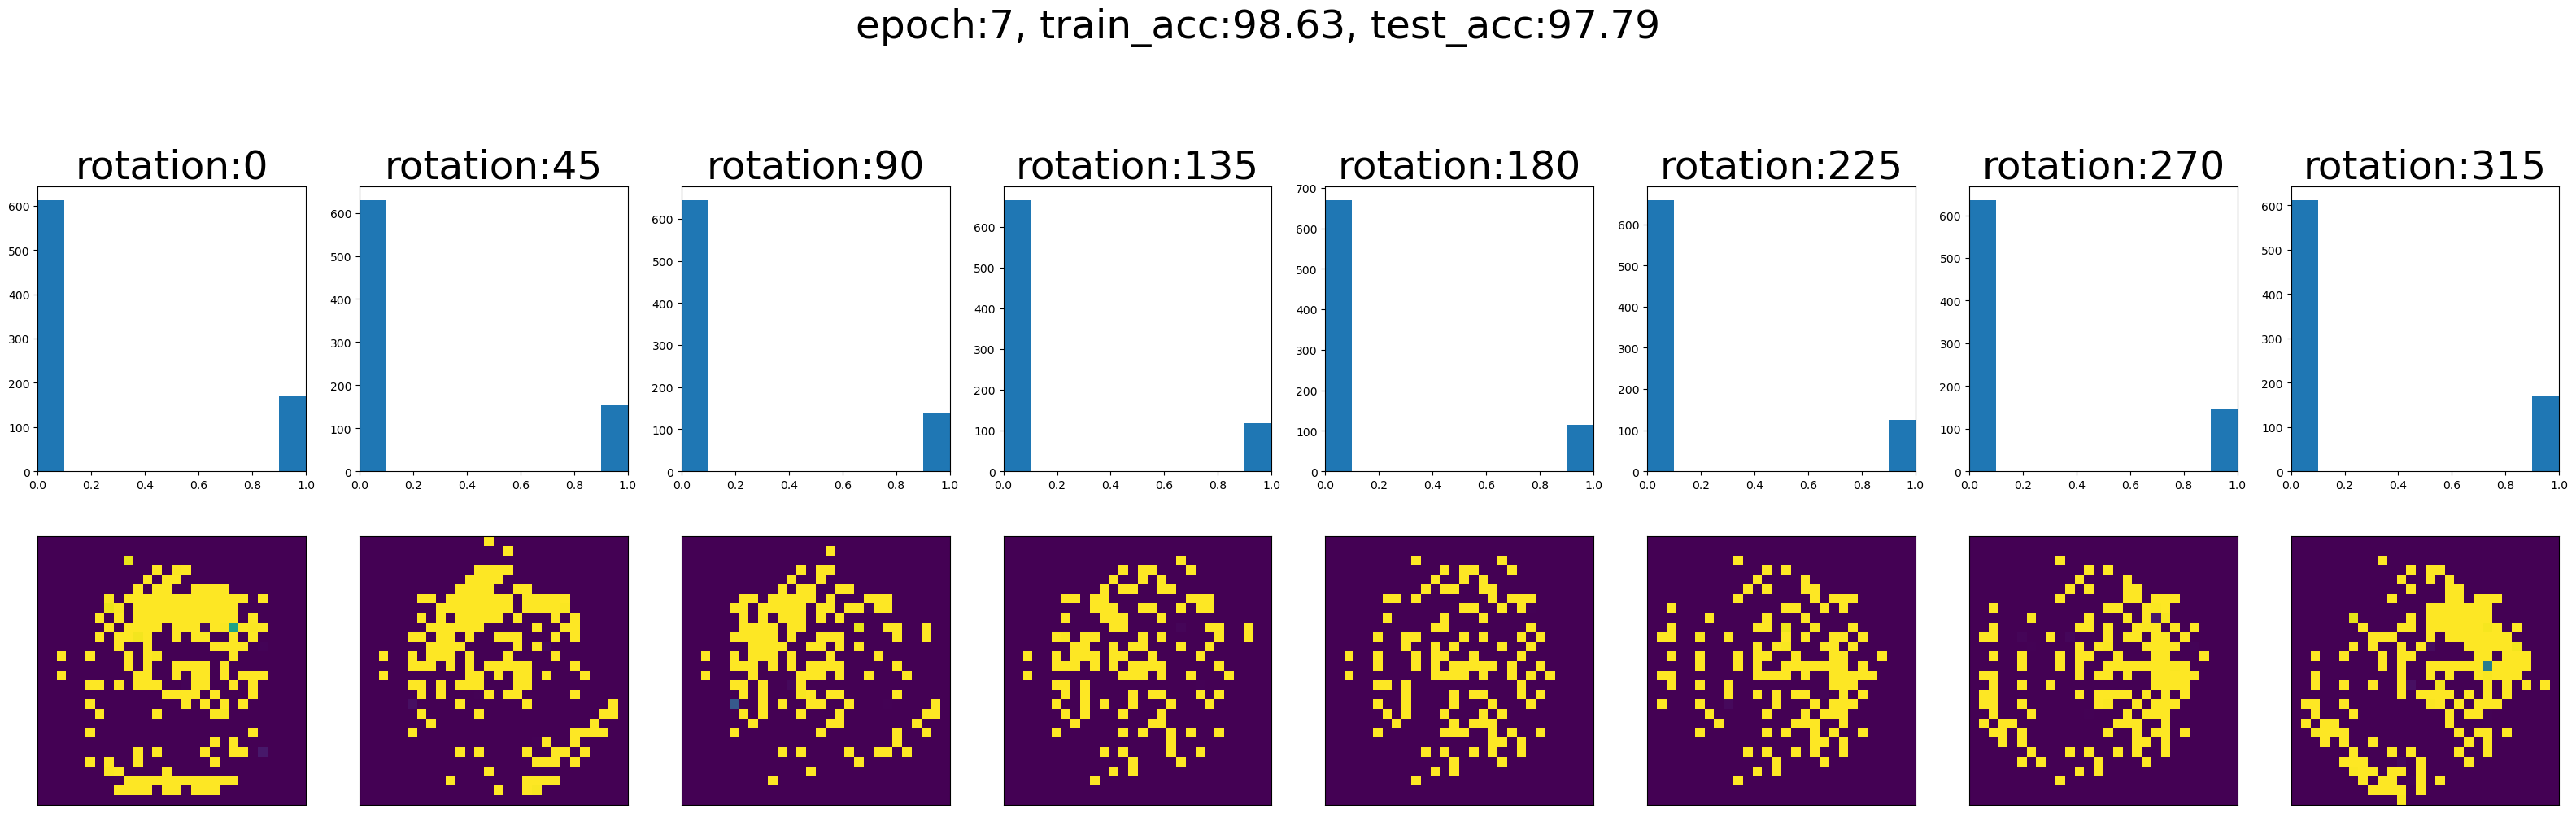

 80%|███████████████████████████████████▏        | 8/10 [04:45<01:18, 39.07s/it]

epoch 9/10: train_loss=0.03542, test_loss=0.09434, train_acc:98.67, test_acc:97.87
Model saved! Validation accuracy improved from 97.791165 to 97.870649


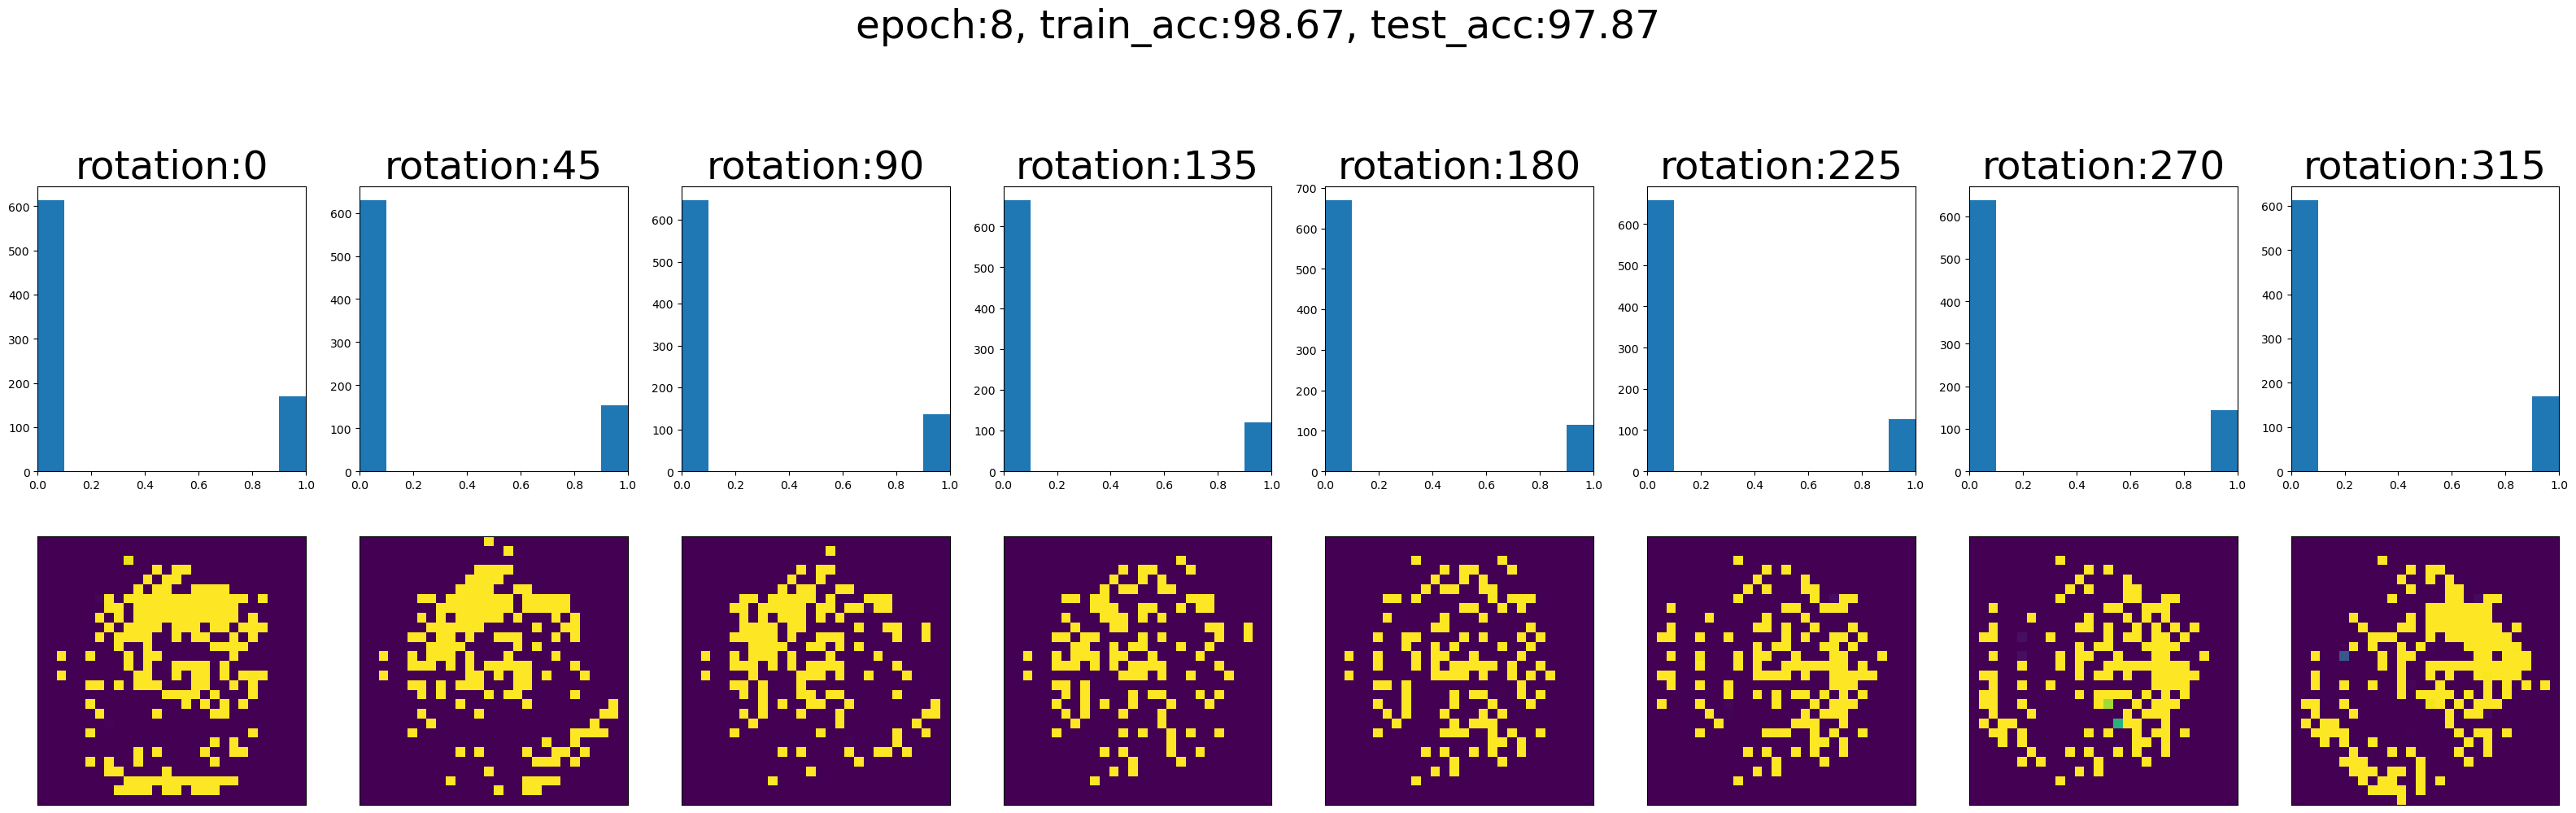

 90%|███████████████████████████████████████▌    | 9/10 [05:25<00:39, 39.19s/it]

epoch 10/10: train_loss=0.03462, test_loss=0.09530, train_acc:98.76, test_acc:97.98
Model saved! Validation accuracy improved from 97.870649 to 97.981509


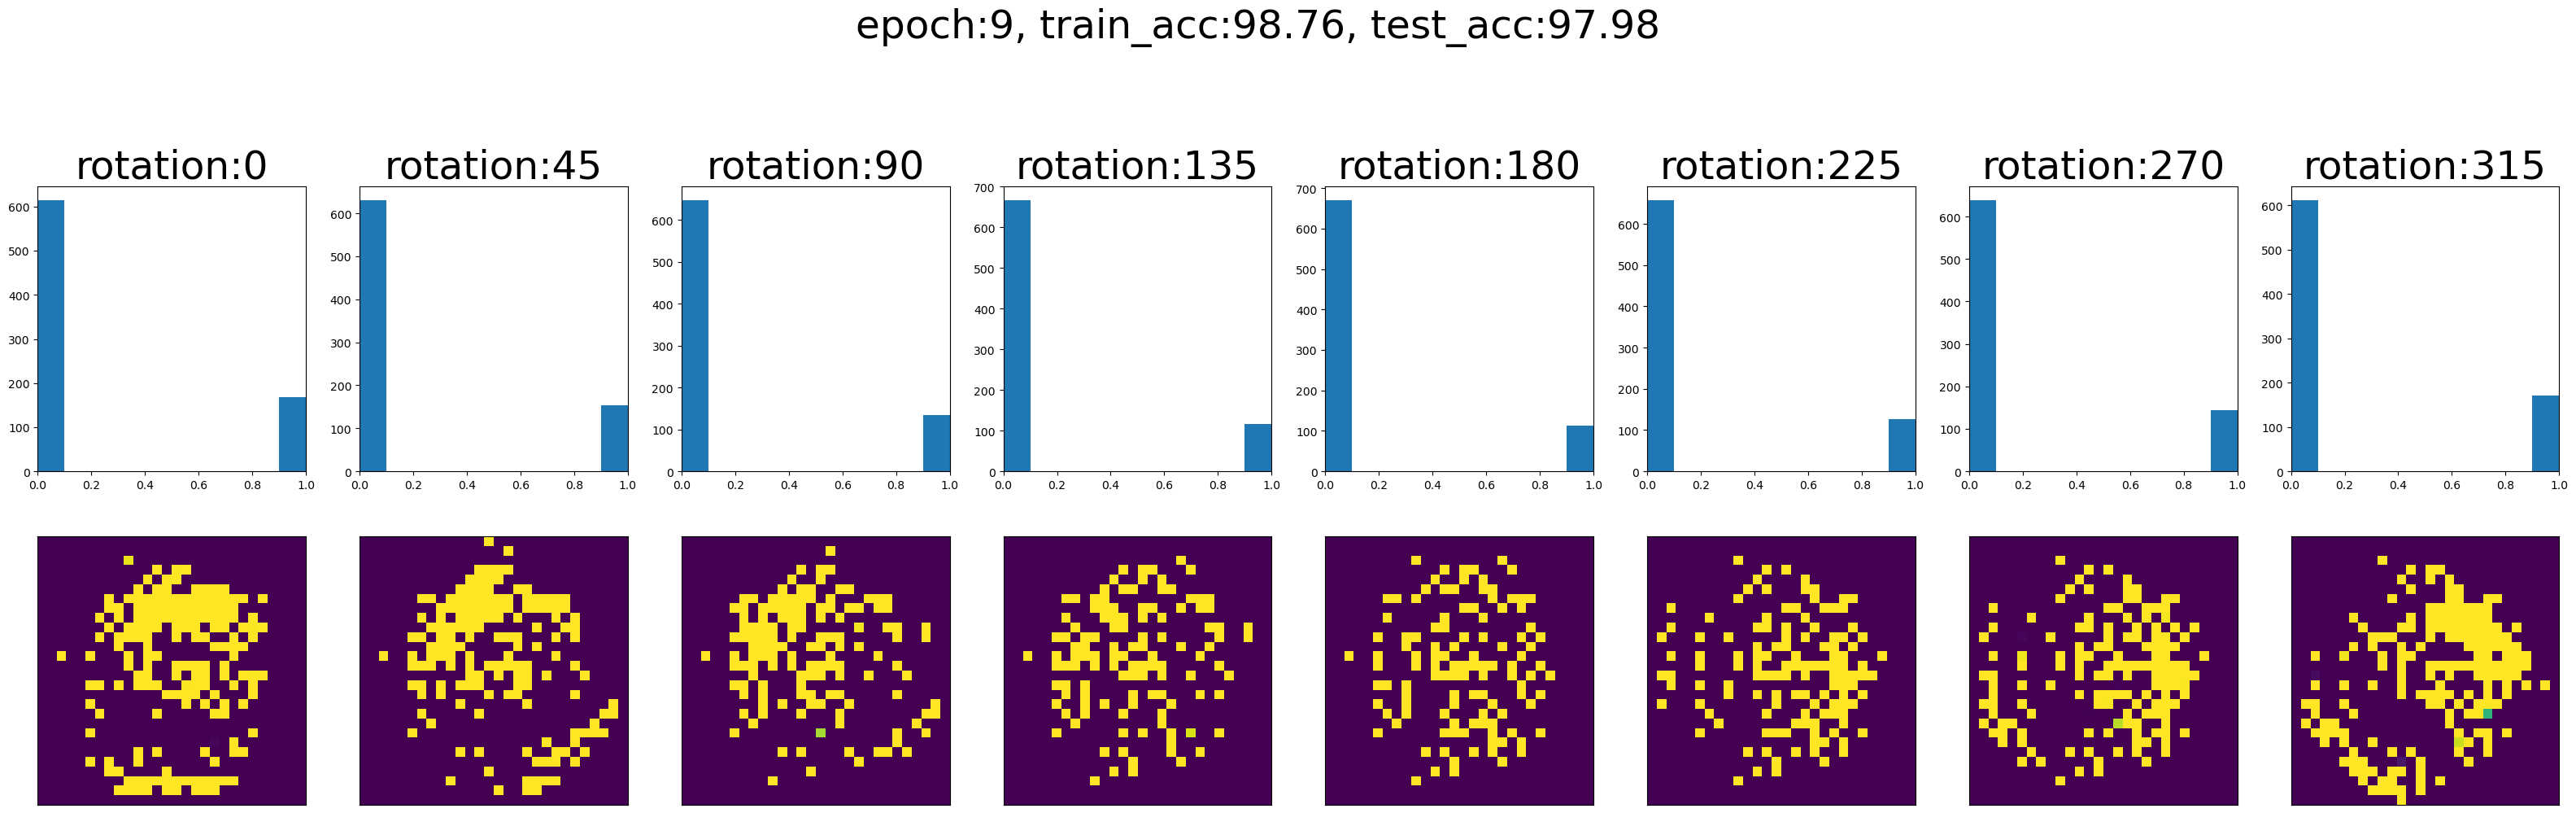

100%|███████████████████████████████████████████| 10/10 [06:05<00:00, 36.51s/it]


In [32]:

gpu = torch.device('cuda:6')

ML_model_name = "fc_stg_layered_param_modular_model_sigmoid"

epochs = 10
param_dim = num_rot
dropout = 0

# stg=True
# for stg,include_B_in_input,non_param_stg in [(True,False,True),(True,False,False),(False,False,False),(False,True,False)]:
# for stg,include_B_in_input,non_param_stg in [(False,False,False),(False,True,False),(True,False,True),(True,False,False),]:
for stg,include_B_in_input,non_param_stg,train_sigma in [(True,False,False,False),]:

    for hyper_hidden_dim in [[64,128]]: #[[64,128],[1000],[32,64,128]]
        for hidden_dims in [[128,64]]: #[[],[128,64]]
            for learning_rate in [5e-4]:
                for stg_regularizer in [5e-2]: #[5e-1,1e-1,5e-2,1e-2]

                    add_name = ""
                    add_name += "_"+"_".join(np.array([input_dim]+hidden_dims+[output_dim]).astype(str))
                    add_name += "_hyper_"+"_".join(np.array([param_dim]+hyper_hidden_dim+[input_dim]).astype(str))

                    add_foldername = ""
                    if include_B_in_input:
                        add_foldername = "include_B_in_input"
                    if stg==True:
                        add_foldername = "_err_crcted"
                        if non_param_stg==True:
                            add_foldername += "_non_param_stg"
                        
                    root_fname = "/data2/rsristi/FeatureSelection/Trained_Model_mnist/Trained_Model_mnist_stg_{}{}".format(stg,add_foldername) #"./Trained_Model_mnist" #/data2/rsristi/FeatureSelection
                    if not os.path.exists(root_fname):
                        os.mkdir(root_fname)

                    model_path = "{}/{}_{}_{}_lr_{}_stg_lr_{}{}.model".format(root_fname,ML_model_name,digits[0],digits[1],str(learning_rate).replace(".", "_"),str(stg_regularizer).replace(".","_"),add_name)

                    loss_path = model_path.replace("model","mat")
                    plots_folder = model_path.replace(".model","")
                    if not os.path.exists(plots_folder):
                        os.mkdir(plots_folder)

                    print(model_path.replace(root_fname,""))
#                     if os.path.exists(model_path):
#                         print("Already Exists")
#                         continue

                    
                    # Load model architecture
                    model = models.__dict__[ML_model_name](input_dim, hidden_dims, output_dim, param_dim, hyper_hidden_dim, dropout,include_B_in_input=include_B_in_input,non_param_stg=non_param_stg,train_sigma=train_sigma)
                    model = model.to(gpu).float()
                    print(model)
                    criterion = nn.BCELoss()  
                    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999))

                    test_acc_array = [0]
                    train_acc_array = [0]
                    train_loss_array = [0]
                    test_loss_array = [0]
                    sigma = []
                    data = tqdm(range(epochs), leave=True)
                    for epoch in data:
                        

                        train_loss = 0
                        test_loss = 0
                        train_count = 0
                        test_count = 0
                        if epoch>0:
                            for batch, (input, target, B) in enumerate(train_dataloader):

                                model.train()

                                input = input.to(gpu).float()
                                target = target.to(gpu).float()
                                B = B.to(gpu).int()/rotations[1]
                                B = F.one_hot((B).to(int),num_classes=num_rot).float()
                                output = model(input,B)
                                output = torch.squeeze(output)
                                loss = criterion(output, torch.squeeze(target)) #.long()

                                temp = model.gates.mu
                                grads = temp.squeeze().cpu().detach().numpy()

                                stg_loss = torch.mean(torch.abs(model.reg((model.gates.mu)))) 
#                                 print(loss.item(),stg_loss.item())
                                loss += stg_regularizer*stg_loss

                                optimizer.zero_grad()   
                                with torch.autograd.set_detect_anomaly(True):
                                    loss.backward()
                                nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0, norm_type=2)
                                optimizer.step()

                                loss_value = loss.item()
                                train_loss += loss.item()
                                train_count += len(input)

                    #     if True:#(epoch%5==0) or (epoch==epochs-1):
                        model.eval()
                        sigma.append(model.gates.sigma.detach().cpu().numpy()[0])
                        
                        train_acc_batch = []
                        for batch, (input, target, B) in enumerate(train_dataloader):
                            input = input.to(gpu).float()
                            target = target.to(gpu).float()
                    #             B = B.to(gpu).float()[:,None]/360
                            B = B.to(gpu).int()/rotations[1]
                            B = F.one_hot((B).to(int),num_classes=num_rot).float()
                            output = model(input,B)
                            output = torch.squeeze(output)
                            loss = criterion(output, torch.squeeze(target))
                            train_acc_batch.append(accuracy_score((output>0.5).float().detach().cpu().numpy(), target.detach().cpu().numpy()))
                    #                 weights = model.lstm.weight_ih_l0
                    #                 l1_loss = torch.sum(torch.abs(weights))
                    #                 loss +=  l1_regularizer*l1_loss
                            loss += stg_regularizer*torch.mean(model.reg((model.gates.mu))) 
                    #                 loss += model.l0_reg
                            train_loss += loss.item()*len(input)
                            train_count += len(input)
                        train_acc = np.mean(train_acc_batch)*100
                        train_acc_array.append(train_acc)
                        train_loss_array.append(train_loss/train_count)

                        test_acc_batch = []
                        for batch, (input, target, B) in enumerate(test_dataloader):
                            input = input.to(gpu).float()
                            target = target.to(gpu).float()
                    #             B = B.to(gpu).float()[:,None]/360
                            B = B.to(gpu).int()/rotations[1]
                            B = F.one_hot((B).to(int),num_classes=num_rot).float()
                            output = model(input,B)
                            output = torch.squeeze(output)

                            test_acc_batch.append(accuracy_score((output>0.5).float().detach().cpu().numpy(), target.detach().cpu().numpy()))
                            loss = criterion(output, torch.squeeze(target))
                    #                 weights = model.lstm.weight_ih_l0
                    #                 l1_loss = torch.sum(torch.abs(weights))
                    #                 loss +=  l1_regularizer*l1_loss
                            loss += stg_regularizer*torch.mean(model.reg(model.gates.mu)) 
                    #                 loss += model.l0_reg
                            test_loss += loss.item()*len(input)
                            test_count += len(input)
                        test_acc = np.mean(test_acc_batch)*100
                        test_acc_array.append(test_acc)
                        test_loss_array.append(test_loss/test_count)

                        print("epoch {}/{}: train_loss={:.5f}, test_loss={:.5f}, train_acc:{:.2f}, test_acc:{:.2f}".format(epoch+1,epochs,train_loss/train_count,test_loss/test_count,train_acc,test_acc))

                        if (test_acc == np.max(test_acc_array)):
                            torch.save(model.state_dict(), model_path)
                            print('Model saved! Validation accuracy improved from {:3f} to {:3f}'.format(np.max(test_acc_array[:-1]), np.max(test_acc_array)))
                        scipy.io.savemat(loss_path, {'train_loss_array': train_loss_array,'test_loss_array': test_loss_array,'train_acc': train_acc_array,'test_acc': test_acc_array})

                        B = torch.tensor(rotations).to(gpu).int()/rotations[1]
                        B = F.one_hot((B).to(int),num_classes=num_rot).float()

                        mu = model.gates.get_feature_importance(B)
                        mu = mu.detach().cpu().numpy()

                        fig,ax = plt.subplots(2,8,figsize=(5*num_rot,5*2))
                        for rotation_idx in range(len(rotations)):
                            plot_pixels = mu[rotation_idx].copy()

                            ax[0,rotation_idx].hist(plot_pixels)
                            ax[0,rotation_idx].set_xlim([0,1])
                            
#                             plt.subplot(1,num_rot,rotation_idx+1)
                            ax[1,rotation_idx].imshow(mu[rotation_idx].reshape(28,28))
                            ax[0,rotation_idx].set_title("rotation:{}".format(rotations[rotation_idx]),fontsize=35)
                            ax[1,rotation_idx].set_xticks([])
                            ax[1,rotation_idx].set_yticks([])
                        plt.suptitle("epoch:{}, train_acc:{:.2f}, test_acc:{:.2f}".format(epoch,train_acc,test_acc),fontsize=35,y=1.1)
#                         plt.savefig(plots_folder+"/epoch_{}.png".format(epoch))
                        plt.show()


In [13]:
torch.mean(model.reg(model.gates.mu)),model.gates.sigma.detach().cpu().numpy()[0]

(tensor(0.6212, device='cuda:6', grad_fn=<MeanBackward0>), 0.014797728)

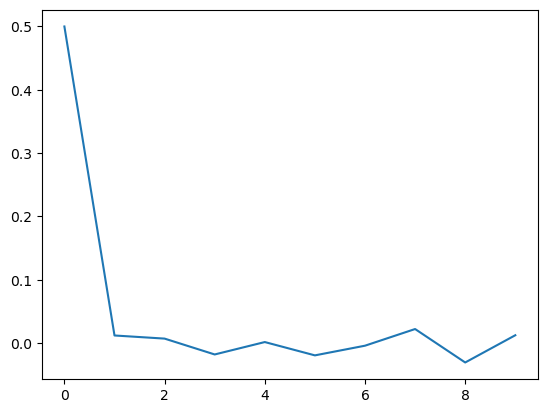

In [15]:
plt.plot(sigma)

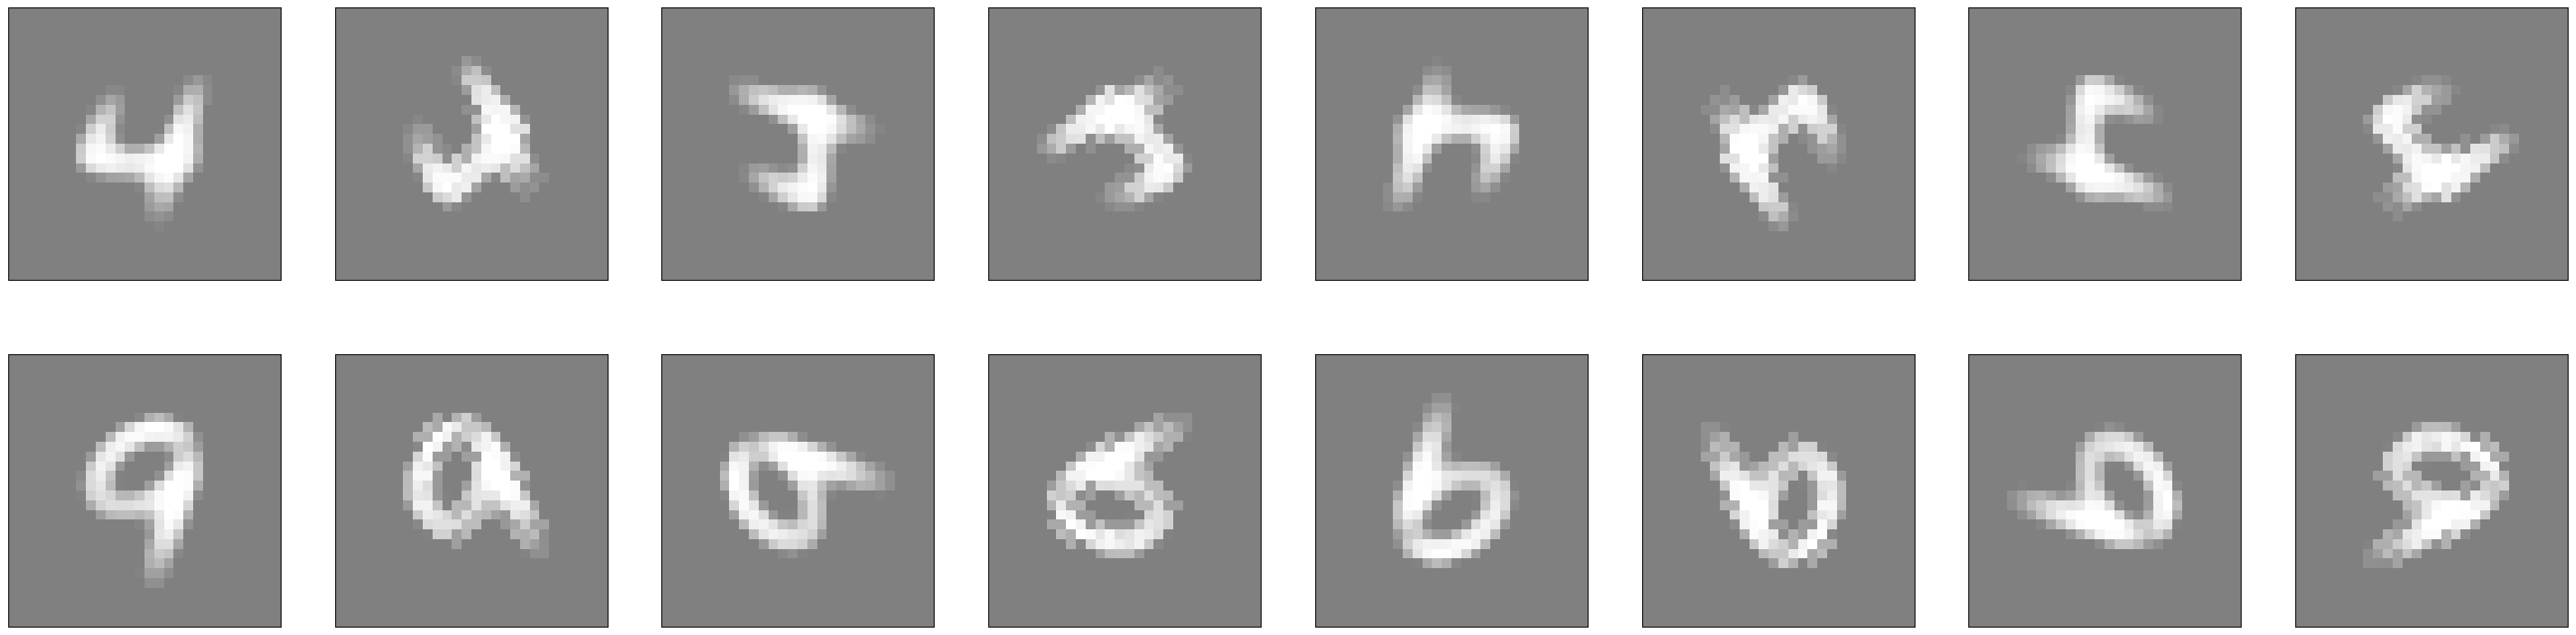

In [20]:
# temp = np.random.choice([0,1],p=[0.4,0.6])
digits_pixels = {}
count = 0

for i in range(len(testset_filtered)):
#     if (testset_filtered[i][1]==0 and testset_filtered[i][2]==rotations[0]):
    key = "digit_{}_rotation_{}".format(testset_filtered[i][1],testset_filtered[i][2])
    if key not in digits_pixels:
        digits_pixels[key]=[]
#         if count<100:
    digits_pixels[key].append(testset_filtered[i][0].numpy())
#         count=count+1

digits_median = {}
for key in digits_pixels:
    digits_pixels[key] = np.array(digits_pixels[key])
    digits_median[key] = np.median(digits_pixels[key],axis=0)   
    
fig,ax = plt.subplots(2,8,figsize=(5*num_rot,5*2))
for digit in [0,1]:
    for rotation_idx,rot in enumerate(rotations):
        key = "digit_{}_rotation_{}".format(digit,rot)
        ax[digit,rotation_idx].imshow(digits_median[key].reshape(28,28),cmap='gray',vmin=-1)
#         ax[digit,rotation_idx].imshow(digits_median["digit_0_rotation_0"].reshape(28,28),cmap='gray',vmin=0,alpha=0.5)
        ax[digit,rotation_idx].set_xticks([])
        ax[digit,rotation_idx].set_yticks([])
# plt.hist(temp)

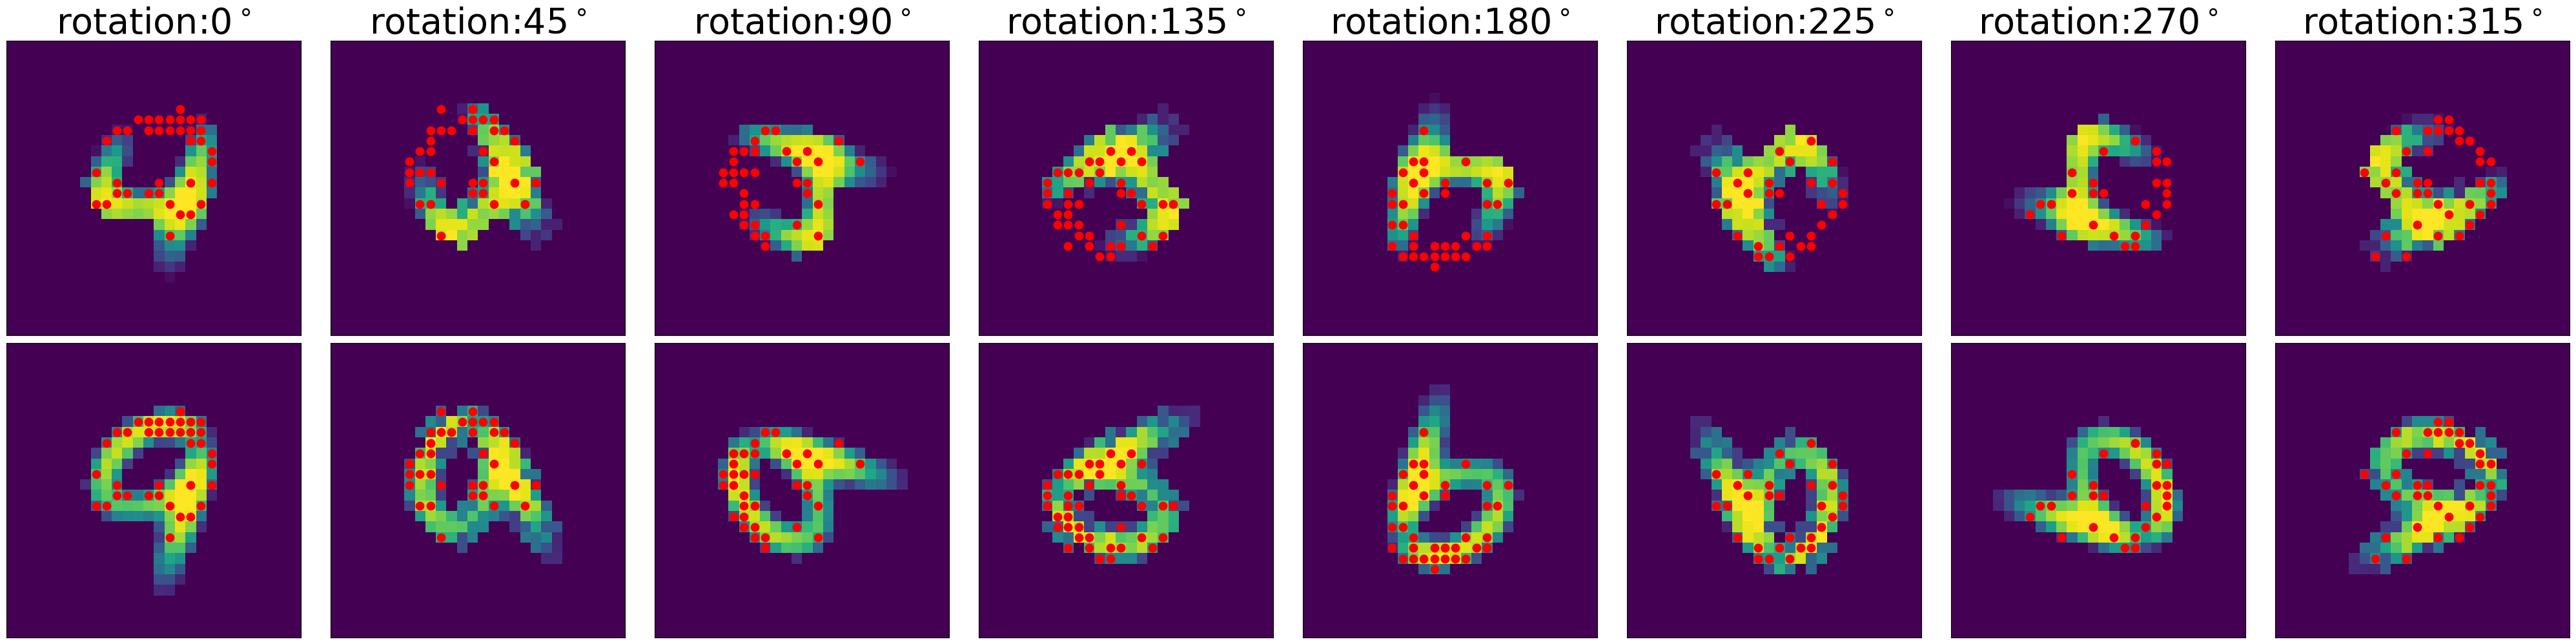

In [24]:
# for stg,include_B_in_input,non_param_stg,train_sigma in [(True,False,False,False),]:

#     for hyper_hidden_dim in [[64,128]]: #[[64,128],[1000],[32,64,128]]
#         for hidden_dims in [[128,64]]: #[[],[128,64]]
#             for learning_rate in [5e-4]:
#                 for stg_regularizer in [3e-1]:


model_path = '/data2/rsristi/FeatureSelection/Trained_Model_mnist/Trained_Model_mnist_stg_True_err_crcted/fc_stg_layered_param_modular_model_sigmoid_4_9_lr_0_0005_stg_lr_0_3_784_128_64_1_hyper_8_64_128_784.model'
model = models.__dict__[ML_model_name](input_dim, hidden_dims, output_dim, param_dim, hyper_hidden_dim, dropout,include_B_in_input=include_B_in_input,non_param_stg=non_param_stg)
model = model.to(gpu).float()
#                 print(model)
model.load_state_dict(torch.load(model_path))
model.eval()

B = torch.tensor(rotations).to(gpu).int()/rotations[1]
B = F.one_hot((B).to(int),num_classes=num_rot).float()

mu = model.gates.get_feature_importance(B)
mu = mu.detach().cpu().numpy()



idxs_digits_presence = {}
for rotation_idx,rot in enumerate(rotations):
#                     plt.subplot(lr_idx,num_rot,rotation_idx+1)
    for digit in [0,1]:
        key = "digit_{}_rotation_{}".format(digit,rot)
        key_idx = "rotation_{}".format(rot)
        if key not in idxs_digits_presence:
            idxs_digits_presence[key_idx] = (digits_median[key]>0.1).copy()
            
        else:
            idxs_digits_presence[key_idx] = np.any((idxs_digits_presence[key_idx],(digits_median[key]>0.1)),axis=0)
#         print(digit,np.sum(idxs_digits_presence[key_idx]))

fig,ax = plt.subplots(2,8,figsize=(5*num_rot,5*2))
for rotation_idx,rot in enumerate(rotations):
#                     plt.subplot(lr_idx,num_rot,rotation_idx+1)
    for digit in [0,1]:
        key = "digit_{}_rotation_{}".format(digit,rot)
        key_idx = "rotation_{}".format(rot)    
        plot_pixels = digits_median[key].copy()
        plot_pixels[~idxs_digits_presence[key_idx]] = 0
#         plot_pixels[idxs_digits_presence[key_idx]] = 1
    #     plt.figure()
        ax[digit,rotation_idx].imshow(plot_pixels.reshape(28,28))
        mu_plot = mu[rotation_idx].copy()
        mu_plot[~idxs_digits_presence[key_idx]] = 0
        mu_plot = mu_plot.reshape(28,28)
        np.where(mu_plot>0.5)
        x_idx,y_idx = np.where(mu_plot>0.5)
        ax[digit,rotation_idx].scatter(y_idx,x_idx,color="red",s=80 )
        if digit==0:
            ax[digit,rotation_idx].set_title("rotation:{}$^\circ$".format(rotations[rotation_idx]),fontsize=40,)
        ax[digit,rotation_idx].set_xticks([])
        ax[digit,rotation_idx].set_yticks([])
        
plt.tight_layout()    
plt.subplots_adjust(wspace=0.1, hspace=0.02) 
# plt.savefig("./plots_NeurIPS/mnist.svg")


In [25]:
model_path

'/data2/rsristi/FeatureSelection/Trained_Model_mnist/Trained_Model_mnist_stg_True_err_crcted/fc_stg_layered_param_modular_model_sigmoid_4_9_lr_0_0005_stg_lr_0_3_784_128_64_1_hyper_8_64_128_784.model'

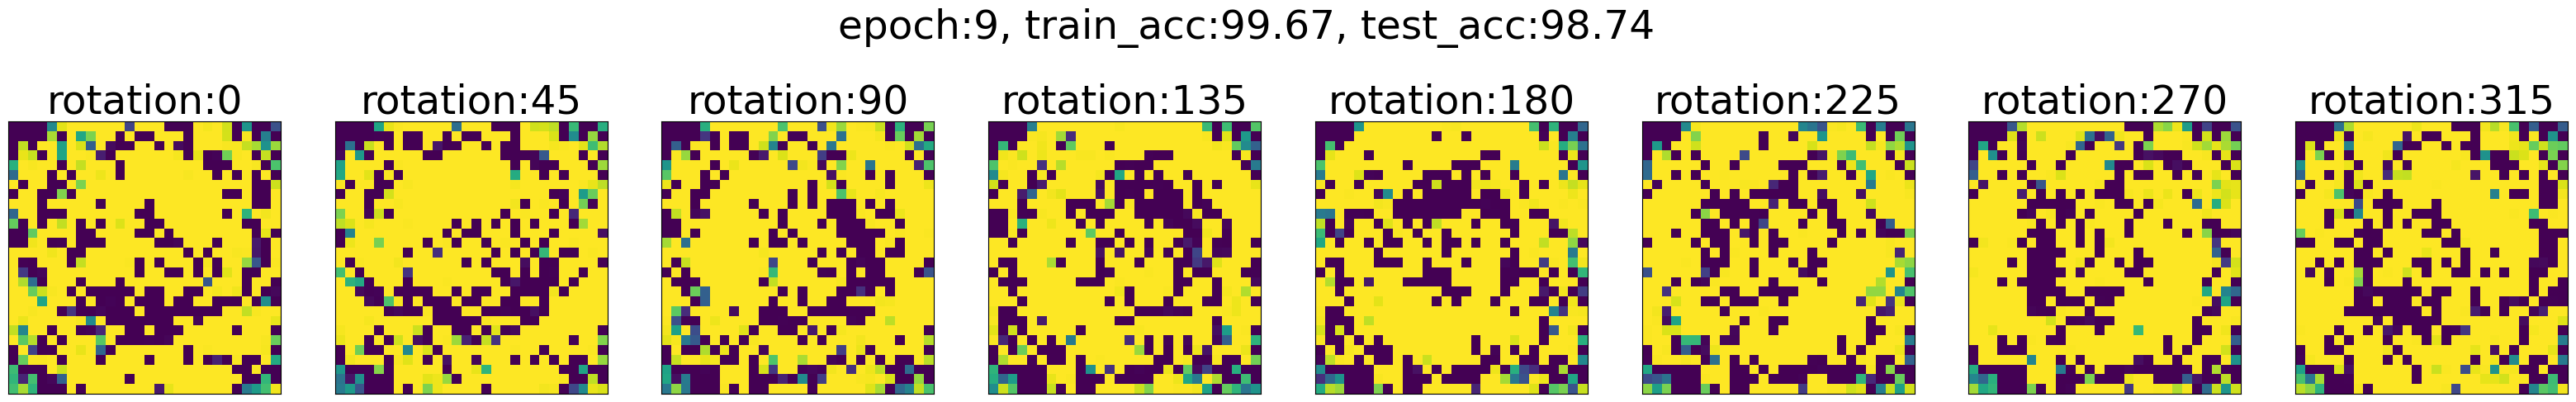

In [4]:
plt.figure(figsize=(5*num_rot,5))
for rotation_idx in range(len(rotations)):
    plt.subplot(1,num_rot,rotation_idx+1)
    plt.imshow(mu[rotation_idx].reshape(28,28))
    plt.title("rotation:{}".format(rotations[rotation_idx]),fontsize=35)
    plt.xticks([])
    plt.yticks([])
plt.suptitle("epoch:{}, train_acc:{:.2f}, test_acc:{:.2f}".format(epoch,train_acc,test_acc),fontsize=35,y=1.1)
#                         plt.savefig(plots_folder+"/epoch_{}.png".format(epoch))
plt.show()